In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set up the mesh and create finite element space relative to the mesh
mesh = UnitSquareMesh(16, 16, "crossed")
V = FunctionSpace(mesh, "Lagrange", 2)

In [3]:
# Define boundary condition u = 0 at x = 0, u = 1 at x = 1.
def left_boundary(x, on_boundary):
    return near(x[0], 0, DOLFIN_EPS_LARGE) and on_boundary

def right_boundary(x, on_boundary):
    return near(x[0], 1.0, DOLFIN_EPS_LARGE) and on_boundary

Gamma_0 = DirichletBC(V, Constant(0.0), left_boundary)
Gamma_1 = DirichletBC(V, Constant(1.0), right_boundary)
bcs = [Gamma_0, Gamma_1]

In [4]:
# Define variational problem for initial guess (q(u)=1, i.e., m=0)

u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v)) * dx
f = Constant(0.0)
L = f * v * dx
A, b = assemble_system(a, L, bcs)

u_k = Function(V)
U_k = u_k.vector()
solve(A, U_k, b)   # solve(A, u_k.vector(), b)

1

In [5]:
# The Dirichlet boundary conditions for the incremental solution du in the
# nonlinear problem to be solved in each Newton iteration are somewhat
# different than the conditions for u. Assuming that u_k already fulfills 
# the Dirichlet conditions for u, du must be zero at the boundaries where the
# Dirichlet conditions apply. Thus, we define the new boundary conditions for
# the incremental solution du in each linearized variational problem
Gamma_0_du = DirichletBC(V, Constant(0.0), left_boundary)
Gamma_1_du = DirichletBC(V, Constant(0.0), right_boundary)
bcs_du = [Gamma_0_du, Gamma_1_du]

In [6]:
# Define q(u) = (1+u)^m and its derivative Dq(u) = m*(1+u)^(m-1)
m = 2
def qq(u):
    return (1+u)**m

def Dqq(u):
    return m*(1+u)**(m-1)

# Set up the bilinear and linear forms resulted from the linearized
# variational problem

du = TrialFunction(V)
v = TestFunction(V)
a = dot(qq(u_k) * grad(du), grad(v)) * dx \
    + dot(Dqq(u_k) * du * grad(u_k), grad(v))*dx
L = -dot(qq(u_k)*grad(u_k), grad(v))*dx

In [7]:
# Newton iteration
dw = Function(V)
u = Function(V)
omega = 1.0       # relaxation parameter
eps = 1.0
TOL = 1E-5
iter_count = 0
maxIter = 50
while eps > TOL and iter_count < maxIter:
    iter_count += 1
    A, b = assemble_system(a, L, bcs_du)
    solve(A, dw.vector(), b)
    eps = np.linalg.norm(dw.vector().get_local(), ord=np.Inf)
    print("Norm: ", eps)
    u.vector()[:] = u_k.vector() + omega * dw.vector()
    u_k.assign(u)

Norm:  0.18104310793233494
Norm:  0.019835721764219483
Norm:  0.00026934866873970926
Norm:  4.987922493956954e-08


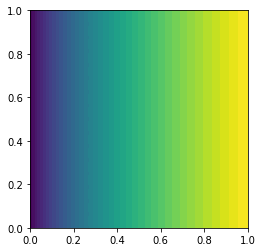

In [8]:
plot(u)

In [53]:
# Another way to implement the above iteration block
dw = Function(V)
u = Function(V)
eps = 1.0
TOL = 1E-5
iter_count = 0
maxIter = 50
while eps > TOL and iter_count < maxIter:
    iter_count += 1
    solve(a == L, dw, bcs_du)
    eps = np.linalg.norm(dw.compute_vertex_values(), ord=np.Inf)
    print("Norm: ", eps)
    u = u_k + dw
    u_k.assign(u)

Norm:  0.18089176288927594
Norm:  0.01981948668759028
Norm:  0.00026926894190851757
Norm:  4.948730775607358e-08
